## Text Summarization Using Flan-T5 Transformer Model

Dataset Source: https://www.kaggle.com/datasets/cuitengfeui/textsummarization-data

#### Install Missing Libraries

In [1]:
%pip install sentencepiece rouge-score nltk tensorboard 
%pip install transformers datasets torch evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=a28aa7f84f2cf94b8e390ee9f4533a217c0cbe9fcf84dd4cad07c56944f3e7c8
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.2 

#### Importing Necessary Libraries

In [2]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import torch
import torch.nn

import pandas as pd
import numpy as np

from tqdm import tqdm
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer, set_seed, AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer 

from datasets import Dataset, DatasetDict, load_metric, load_dataset

import evaluate

!git lfs install

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### HuggingFace Access

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Mount Google Drive

In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


#### Versions of Some Necessary Libraries Used

In [5]:
library_Spacing = 20
print("Python:".rjust(library_Spacing), sys.version[0:6])
print("NumPy:".rjust(library_Spacing), np.__version__)
print("Pandas:".rjust(library_Spacing), pd.__version__)
print("Transformers:".rjust(library_Spacing), transformers.__version__)
print("Torch:".rjust(library_Spacing), torch.__version__)

             Python: 3.9.16
              NumPy: 1.22.4
             Pandas: 1.4.4
       Transformers: 4.26.1
              Torch: 1.13.1+cu116


#### Ingest & Start Preprocessing Training Dataset

In [6]:
parent_dir = "/content/drive/MyDrive/Projects/text-summarization"

train_data_file = os.path.join(parent_dir, "train.csv")

train_df = pd.read_csv(train_data_file)

train_df.drop_duplicates(inplace=True)

train_df.dropna(inplace=True)

train_df.rename(columns={"document": "article", "title": "summary"}, inplace=True)

train_df

,article,summary
0,jason blake of the islanders will miss the res...,blake missing rest of season
1,the u.s. military on wednesday captured a wife...,u.s. arrests wife and daughter of saddam deput...
2,craig bellamy 's future at west ham appeared i...,west ham drops bellamy amid transfer turmoil
3,cambridge - when barack obama sought advice be...,in search for expertise harvard looms large
4,"wall street held on to steep gains on monday ,...",wall street ends a three-day losing streak
...,...,...
19995,a rapidly growing world population and threat ...,u.n. food agency must help more people with le...
19996,ahead of nuclear talks between senior iranian ...,us urges iran to change course on its nuclear ...
19997,airbus ceo thomas enders dismissed a french in...,airbus ceo thomas enders calls eads insider tr...
19998,albania 's central bank said friday it has iss...,central bank licenses a local bank


#### Ingest & Start Preprocessing Evaluation Dataset

In [7]:
eval_data_file = os.path.join(parent_dir, "val.csv")

eval_df = pd.read_csv(eval_data_file)

eval_df.drop_duplicates(inplace=True)

eval_df.dropna(inplace=True)

eval_df.rename(columns={"document": "article", "title": "summary"}, inplace=True)

eval_df

,article,summary
0,mr. emmons also was part of the design team fo...,donn emmons architect of northern california l...
1,"the secret 's out : in `` in &amp; out , '' to...",in &amp; out brings gay sensibilities to mains...
2,indonesia 's top security official said thursd...,top security minister suspects foreign terrori...
3,"<unk> on the tongue , pungent to the nose , gi...",warm up to ginger
4,thirty years after they were written off as de...,vietnamese commandos seek payment from us
...,...,...
995,`` who wants to die with money in the stock ma...,records set for ## contemporary artists
996,the iraqi government 's failure to grasp the s...,iraq far behind in mine clearance
997,the provisional results of the european parlia...,<unk> to remain biggest party group in europea...
998,british prime minister tony blair saturday wel...,gore blair agree to boost cyber commerce


#### Remove Unnecessary Whitespace

In [8]:
train_df["article"] = train_df["article"].str.strip()
train_df["summary"] = train_df["summary"].str.strip()
eval_df["article"] = eval_df["article"].str.strip()
eval_df["summary"] = eval_df["summary"].str.strip()

#### Visualize Length of Each Article

The longest string (in words) in this dataset is 74 words.


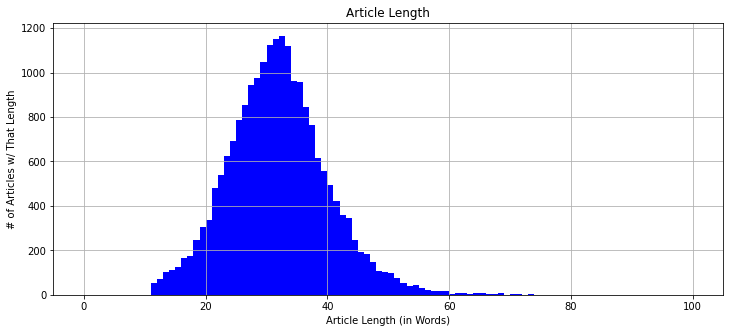

In [9]:
train_df['article_lengths'] = train_df['article'].str.split().apply(len)
eval_df['article_lengths'] = eval_df['article'].str.split().apply(len)

article_lengths = pd.concat([pd.Series(train_df['article_lengths']), pd.Series(eval_df['article_lengths'])])

print(f"The longest string (in words) in this dataset is {max(article_lengths)} words.")

n = 100
article_lengths.hist(grid=True, color="Blue", figsize=(12,5), bins=n, range=(0, n))
plt.suptitle('')
plt.xlabel('Article Length (in Words)')
plt.ylabel('# of Articles w/ That Length')
plt.title('Article Length')
plt.show()

#### Visualize Length of Each Summary

The longest string (in words) in this dataset is 26 words.


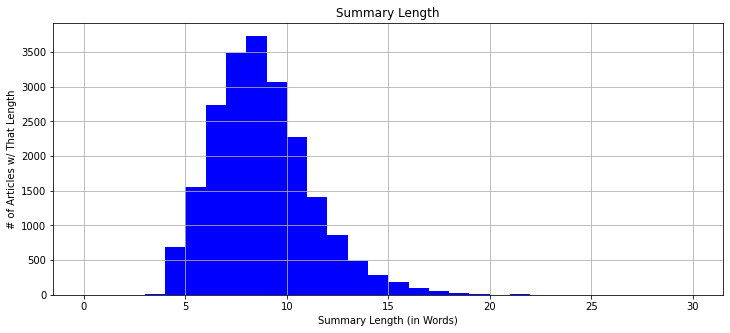

In [10]:
train_df['summary_lengths'] = train_df['summary'].str.split().apply(len)
eval_df['summary_lengths'] = eval_df['summary'].str.split().apply(len)

summary_lengths = pd.concat([pd.Series(train_df['summary_lengths']), pd.Series(eval_df['summary_lengths'])])

print(f"The longest string (in words) in this dataset is {max(summary_lengths)} words.")

n = 30
summary_lengths.hist(grid=True, color="Blue", figsize=(12,5), bins=n, range=(0, n))
plt.suptitle('')
plt.xlabel('Summary Length (in Words)')
plt.ylabel('# of Articles w/ That Length')
plt.title('Summary Length')
plt.show()

#### Trimmed Dataset Based on Article &/or Summary Length

In [11]:
# trim training & evaluation article lengths to have no more than 50 words
train_df = train_df[train_df['article_lengths'] < 51]
train_df = train_df[train_df['article_lengths'] > 17]

eval_df = eval_df[eval_df['article_lengths'] < 51]
eval_df = eval_df[eval_df['article_lengths'] > 17]

# trim training & evaluation article lengths to have no more than 16 words
train_df = train_df[train_df['summary_lengths'] < 17]
eval_df = eval_df[eval_df['summary_lengths'] < 17]

train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

max_article_length = max(max(train_df['article_lengths']), max(eval_df['article_lengths']))
max_summary_length = max(max(train_df['summary_lengths']), max(eval_df['summary_lengths']))

print(f"The longest string (in words) in this dataset is {max_article_length} words.")
print(f"The longest string (in words) in this dataset is {max_summary_length} words.")

# drop unnecessary features
train_df = train_df.drop(columns=['article_lengths', 'summary_lengths'])
eval_df = eval_df.drop(columns=['article_lengths', 'summary_lengths'])

train_df.head()

The longest string (in words) in this dataset is 50 words.
The longest string (in words) in this dataset is 16 words.


,article,summary
0,jason blake of the islanders will miss the res...,blake missing rest of season
1,the u.s. military on wednesday captured a wife...,u.s. arrests wife and daughter of saddam deput...
2,craig bellamy 's future at west ham appeared i...,west ham drops bellamy amid transfer turmoil
3,cambridge - when barack obama sought advice be...,in search for expertise harvard looms large
4,"wall street held on to steep gains on monday ,...",wall street ends a three-day losing streak


#### Determine Longest Token Lengths

In [12]:
MODEL_CKPT = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                             truncation=True, 
                                             padding=True,
                                             batched=True, 
                                             batch_size=None)

train_a_len = [len(tokenizer.encode(a)) for a in train_df["article"]]
train_s_len = [len(tokenizer.encode(a)) for a in train_df["summary"]]

eval_a_len = [len(tokenizer.encode(a)) for a in eval_df["article"]]
eval_s_len = [len(tokenizer.encode(a)) for a in eval_df["summary"]]

max_art_len = max(max(train_a_len), max(eval_a_len))
max_sum_len = max(max(train_s_len), max(eval_s_len))

print(f"The longest article length is {max_art_len} tokens.")
print(f"The longest summary length is {max_sum_len} tokens.")

The longest article length is 116 tokens.
The longest summary length is 42 tokens.


#### Convert DataFrame to Dataset & Split into Train & Eval Datasets

In [13]:
# Convert pandas dataframe to a dataset
train_ds = Dataset.from_pandas(train_df)
eval_ds = Dataset.from_pandas(eval_df)

# Combine the train/test/valid into one datasetdict
dataset = DatasetDict({
    'train' : train_ds,
    'eval' : eval_ds
})

print('Training Data Shape:', dataset['train'].shape)
print('Validation Data Shape:', dataset['eval'].shape)

Training Data Shape: (18776, 2)
Validation Data Shape: (932, 2)


#### Define Basic Constants/Values

In [14]:
MODEL_CKPT = "google/flan-t5-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-text_summarization_data_3_epochs"

DEVICE = torch.device("cuda")
set_seed(42)

BATCH_SIZE = 16
NUM_OF_EPOCHS = 6

LEARNING_RATE = 2e-5
STRATEGY = "epoch"

MAX_INPUT_LENGTH = max_art_len + 4
MAX_TARGET_LENGTH = max_sum_len + 4

WEIGHT_DECAY = 0.01
REPORTS_TO = "tensorboard"

PREFIX = "summarize: "

#### Instantiate both Tokenizer and Model

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                             truncation=True, 
                                             padding=True, 
                                             batched=True, 
                                             batch_size=None)

model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT)

#### Create Function to Tokenize & Return Necessary Inputs for Batches of Samples

In [16]:
def convert_examples_to_features(ex_batch, padding="max_length"):
    inputs = [PREFIX + doc for doc in ex_batch["article"]]
    
    input_encodings = tokenizer(inputs, 
                                max_length=MAX_INPUT_LENGTH, 
                                padding="max_length",
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(ex_batch['summary'], 
                                     max_length=MAX_TARGET_LENGTH, 
                                     truncation=True,
                                     padding="max_length")
    
    if padding == "max_length":
        target_encodings["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in target_encodings["input_ids"]
        ]
    
    return {"input_ids" : input_encodings["input_ids"],
            "attention_mask" : input_encodings["attention_mask"],
            "labels" : target_encodings["input_ids"],}

#### Apply Above Function to Dataset

In [17]:
encoded_ds = dataset.map(convert_examples_to_features, batched=True)
encoded_ds.set_format(type="torch", columns=['input_ids', 'labels', 'attention_mask'])

Map:   0%|          | 0/18776 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/932 [00:00<?, ? examples/s]

#### Instantiate TrainingArguments

In [18]:
training_args = Seq2SeqTrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    logging_strategy=STRATEGY,
    evaluation_strategy=STRATEGY,
    logging_first_step=True,
    disable_tqdm=False,
    report_to=REPORTS_TO,
    predict_with_generate=True,
    hub_private_repo=True,
    push_to_hub=True)

#### Create Function to Computes Metrics

In [19]:
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we cannot decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

#### Instantiate Data Collator

In [20]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#### Instantiate Trainer

In [21]:
trainer = Seq2SeqTrainer(model=model, 
                  args=training_args,
                  data_collator=seq2seq_data_collator,
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'], 
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/flan-t5-base-text_summarization_data_3_epochs into local empty directory.


#### Train Model

In [22]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, summary. If article, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18776
  Num Epochs = 6
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7044
  Number of trainable parameters = 247577856
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster t

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.007900,1.715040,43.421800,19.898400,40.005900,40.058200,14.501100
2,1.912200,1.702009,44.037400,20.575600,40.591500,40.568300,14.617000
3,1.858800,1.688100,43.949800,20.563300,40.465600,40.511600,14.452800
4,1.824300,1.681192,43.602400,20.484500,40.178400,40.221100,14.507500
5,1.799600,1.677963,43.665200,20.553000,40.220900,40.265100,14.523600
6,1.787600,1.678251,43.599400,20.444600,40.132000,40.169200,14.583700


Saving model checkpoint to flan-t5-base-text_summarization_data_3_epochs/checkpoint-500
Configuration saved in flan-t5-base-text_summarization_data_3_epochs/checkpoint-500/config.json
Configuration saved in flan-t5-base-text_summarization_data_3_epochs/checkpoint-500/generation_config.json
Model weights saved in flan-t5-base-text_summarization_data_3_epochs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in flan-t5-base-text_summarization_data_3_epochs/checkpoint-500/tokenizer_config.json
Special tokens file saved in flan-t5-base-text_summarization_data_3_epochs/checkpoint-500/special_tokens_map.json
Copy vocab file to flan-t5-base-text_summarization_data_3_epochs/checkpoint-500/spiece.model
tokenizer config file saved in flan-t5-base-text_summarization_data_3_epochs/tokenizer_config.json
Special tokens file saved in flan-t5-base-text_summarization_data_3_epochs/special_tokens_map.json
Copy vocab file to flan-t5-base-text_summarization_data_3_epochs/spiece.model
Saving mod

TrainOutput(global_step=7044, training_loss=1.8651155138949926, metrics={'train_runtime': 6183.5219, 'train_samples_per_second': 18.219, 'train_steps_per_second': 1.139, 'total_flos': 1.808016194469888e+16, 'train_loss': 1.8651155138949926, 'epoch': 6.0})

#### Compute & Print Metrics

In [23]:
score = trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, summary. If article, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 932
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

#### Print Out Full Rouge Metric Dictionary

In [24]:
pd.DataFrame(score, index=[f"FLAN-T5"])

,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL,eval_rougeLsum,eval_gen_len,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
FLAN-T5,1.678251,43.5994,20.4446,40.132,40.1692,14.5837,48.4519,19.236,1.218,6.0


### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [25]:
trainer.push_to_hub(commit_message="All Dunn!")

Saving model checkpoint to flan-t5-base-text_summarization_data_3_epochs
Configuration saved in flan-t5-base-text_summarization_data_3_epochs/config.json
Configuration saved in flan-t5-base-text_summarization_data_3_epochs/generation_config.json
Model weights saved in flan-t5-base-text_summarization_data_3_epochs/pytorch_model.bin
tokenizer config file saved in flan-t5-base-text_summarization_data_3_epochs/tokenizer_config.json
Special tokens file saved in flan-t5-base-text_summarization_data_3_epochs/special_tokens_map.json
Copy vocab file to flan-t5-base-text_summarization_data_3_epochs/spiece.model


Upload file pytorch_model.bin:   0%|          | 32.0k/945M [00:00<?, ?B/s]

Upload file runs/Mar13_17-25-08_ddf8f10c20b8/events.out.tfevents.1678734554.ddf8f10c20b8.125.2: 100%|#########…

Upload file runs/Mar13_17-25-08_ddf8f10c20b8/events.out.tfevents.1678728322.ddf8f10c20b8.125.0: 100%|#########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/flan-t5-base-text_summarization_data_3_epochs
   7883972..453df5f  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/flan-t5-base-text_summarization_data_3_epochs
   7883972..453df5f  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'metrics': [{'name': 'Rouge1', 'type': 'rouge', 'value': 43.5994}]}
remote: ----------------------------------------------------------        
remote: Your push was accepted, but with warnings:        
remote: - Warning: empty or missing yaml metadata in repo card        
remote: help: https://huggingface.co/docs/hub/model-cards#model-card-metadata        
remote: ----------------------------------------------------------        
remote: Please 

'https://huggingface.co/DunnBC22/flan-t5-base-text_summarization_data_3_epochs/commit/453df5f163a1ef2c2741604b3a04e52261627828'

### Notes & Other Takeaways From This Project
****
- I decided at the last minute to train this project for 6 epochs instead of 3, but forgot to update the model checkpoint. I will manually change that on the HuggingFace Hub.
****

### Citations

***
- Model Checkpoint
> @misc{https://doi.org/10.48550/arxiv.2210.11416,
doi = {10.48550/ARXIV.2210.11416},  
  url = {https://arxiv.org/abs/2210.11416},
  author = {Chung, Hyung Won and Hou, Le and Longpre, Shayne and Zoph, Barret and Tay, Yi and Fedus, William and Li, Eric and Wang, Xuezhi and Dehghani, Mostafa and Brahma, Siddhartha and Webson, Albert and Gu, Shixiang Shane and Dai, Zhuyun and Suzgun, Mirac and Chen, Xinyun and Chowdhery, Aakanksha and Narang, Sharan and Mishra, Gaurav and Yu, Adams and Zhao, Vincent and Huang, Yanping and Dai, Andrew and Yu, Hongkun and Petrov, Slav and Chi, Ed H. and Dean, Jeff and Devlin, Jacob and Roberts, Adam and Zhou, Denny and Le, Quoc V. and Wei, Jason},
  keywords = {Machine Learning (cs.LG), Computation and Language (cs.CL), FOS: Computer and information sciences, FOS: Computer and information sciences},
  title = {Scaling Instruction-Finetuned Language Models},
  publisher = {arXiv},  
  year = {2022},
  copyright = {Creative Commons Attribution 4.0 International}
}

- Metric (Rouge)
> @inproceedings{lin-2004-rouge,
    title = &quot;{ROUGE}: A Package for Automatic Evaluation of Summaries&quot;,
    author = &quot;Lin, Chin-Yew&quot;,
    booktitle = &quot;Text Summarization Branches Out&quot;,
    month = jul,
    year = &quot;2004&quot;,
    address = &quot;Barcelona, Spain&quot;,
    publisher = &quot;Association for Computational Linguistics&quot;,
    url = &quot;https://www.aclweb.org/anthology/W04-1013&quot;,
    pages = &quot;74--81&quot;,
}
****
